# Telco Customer Churn using Logistic Regression

In this notebook, we predict whether a customer will end their relationship with company.

## 1. Import Required Libraries

Import the requied libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

import joblib

## 2. Load the Dataset

Get the dataset from Kaggle.

In [2]:
original_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
original_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Process the Data

Perform some feature engineering and shuffling the data to reduce bias.

In [3]:
# Function to print all the unique values of each column
def get_unique_values(data):
    for column in data.columns:
        unique_values = data[column].unique()
        print(f"Column: {column}")
        print(f"Unique Values: {unique_values}")
        print("_" * 100)

In [4]:
get_unique_values(original_data)
data = original_data.copy()

Column: customerID
Unique Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
____________________________________________________________________________________________________
Column: gender
Unique Values: ['Female' 'Male']
____________________________________________________________________________________________________
Column: SeniorCitizen
Unique Values: [0 1]
____________________________________________________________________________________________________
Column: Partner
Unique Values: ['Yes' 'No']
____________________________________________________________________________________________________
Column: Dependents
Unique Values: ['No' 'Yes']
____________________________________________________________________________________________________
Column: tenure
Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6

In [5]:
# Shuffle the data to reduce bias
data = data.sample(frac=1)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2044,2550-QHZGP,Male,0,No,No,7,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,128.6,No
2318,6463-HHXJR,Female,0,Yes,Yes,71,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,No,Two year,No,Bank transfer (automatic),100.50,7030.65,No
3187,7682-AZNDK,Male,0,Yes,Yes,34,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,89.85,3091.75,No
7002,9586-JGQKH,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.40,6794.75,No
4832,6478-HRRCZ,Male,0,Yes,No,32,Yes,No,DSL,Yes,...,No,Yes,No,Yes,One year,No,Mailed check,70.50,2201.75,No


In [6]:
# Convert 'TotalCharges' to float
data['TotalCharges'] = data['TotalCharges'].replace(' ', 0.0)
data['TotalCharges'] = data['TotalCharges'].astype(float)

# Columns to map
columns_to_map = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
    'PaymentMethod', 'PaperlessBilling', 'Churn'
]

In [7]:
# Define the mapping for various values
value_mapping = {
    'Female': 1, 
    'Male': 0, 
    'Yes': 1, 
    'No': 0, 
    'No phone service': 0, 
    'DSL': 1, 
    'Fiber optic': 1,
    'No internet service': 0, 
    'Month-to-month': 0, 
    'One year': 1, 
    'Two year': 1, 
    'Electronic check': 0, 
    'Mailed check': 0, 
    'Bank transfer (automatic)': 1, 
    'Credit card (automatic)': 1
}

In [8]:
# Convert the strings to numbers using the map
for column in columns_to_map:
    data[column] = data[column].map(value_mapping)

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2044,2550-QHZGP,0,0,0,0,7,1,0,0,0,...,0,0,0,0,1,0,0,19.50,128.60,0
2318,6463-HHXJR,1,0,1,1,71,1,1,1,1,...,1,0,1,0,1,0,1,100.50,7030.65,0
3187,7682-AZNDK,0,0,1,1,34,1,0,1,0,...,1,0,1,0,0,1,0,89.85,3091.75,0
7002,9586-JGQKH,1,0,1,0,64,1,1,1,0,...,0,1,1,1,1,1,1,105.40,6794.75,0
4832,6478-HRRCZ,0,0,1,0,32,1,0,1,1,...,0,1,0,1,1,0,0,70.50,2201.75,0


In [9]:
x_data = data.drop(['customerID', 'Dependents', 'tenure', 'MultipleLines', 'MonthlyCharges', 'Churn'], axis=1)
y_data = data['Churn']

x_features = x_data.columns.to_list()
print(x_features)

['gender', 'SeniorCitizen', 'Partner', 'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


## 4. Train - Test Split

Split the data for training and testing purposes.

In [10]:
x = x_data.values
y = y_data.values

length = len(y)
print(f"Length of the data: {length}")

split_index = int(length * 0.90)    # 90% training data

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

shape = x_train.shape
print(f"Shape of training data: {shape}")



Length of the data: 7043
Shape of training data: (6338, 15)


## 5. Build the Model using Pipeline

Use **StandardScalar()** for Normalization and **LogisticRegression()** as the model. Parameters include:

* **penalty='l1'** - for regularization. **l1**(Lasso) encourages the model to shrink irrelevant feature coefficients to 0.

* **solver='liblinear'** - optimization algorithm. **liblinear** works well for smaller datasets.
* **max_iter=1000000** - the maximum number of iterations the solver will run to find the best solution.
* **C=1.0** - moderate level of regularization.
* **random_state=50** - sets the seed for random number generation to ensure reproducibility.
* **class_weight='balanced'** - adjusts the weights of the classes based on their frequencies in the data.

In [11]:
pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000000, C=1.0, random_state=50, class_weight='balanced'))
])

## 6. Train the model

Fit the training data using the pipeline.

In [12]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000000,
                                    penalty='l1', random_state=50,
                                    solver='liblinear'))])

## 7. Make Predictions

Make the predictions using the test data.

In [13]:
y_predicted = pipeline.predict(x_test)

## 8. Evaluate the Model

Check the correctness of the model using various metrics.

### a. Accuracy Score

Measures the percentage of correctly predicted instances out of the total instances.

In [14]:
score = accuracy_score(y_test, y_predicted)
print(f"Accuracy Score: {score}")

Accuracy Score: 0.7375886524822695


### b. Confusion Matrix

Summarizes the number of true positives, true negatives, false positives, and false negatives in predictions.

In [15]:
matrix = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[364 140]
 [ 45 156]]


### c. Classification Report

Provides precision, recall, F1-score, and support for each class to evaluate model performance.

In [16]:
report = classification_report(y_test, y_predicted)
print("Classifictaion Report:")
print(report)

Classifictaion Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       504
           1       0.53      0.78      0.63       201

    accuracy                           0.74       705
   macro avg       0.71      0.75      0.71       705
weighted avg       0.79      0.74      0.75       705



### d. ROC-AUC Score

Quantifies the model's ability to distinguish between classes, with higher values indicating better separation.

In [17]:
rocauc = roc_auc_score(y_test, y_predicted)
print(rocauc)

0.7491708126036485


### e. ROC Curve

Plots the trade-off between true positive rate (TPR) and false positive rate (FPR) at various thresholds.

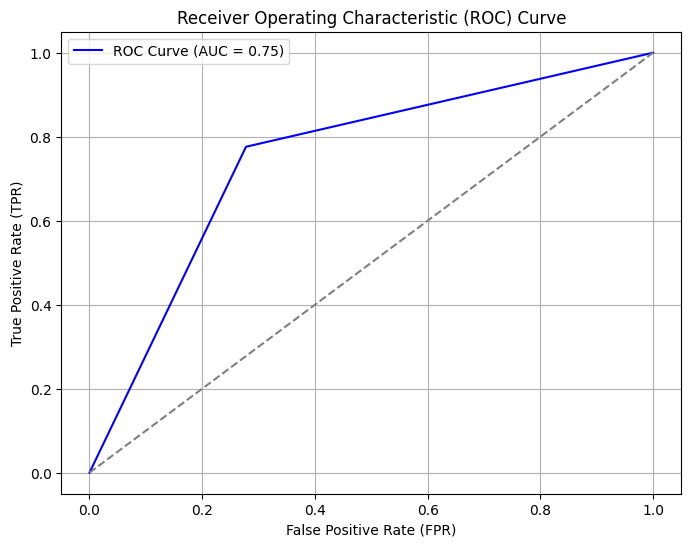

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {rocauc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

## 9. Save the Model

Save the model for later use using **joblib**.

In [19]:
joblib.dump(pipeline, 'logistic_regression_model.pkl')
print("Model saved as logistic_regression_model.pkl")

Model saved as logistic_regression_model.pkl
